In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Activation, Conv2D, BatchNormalization, Add, ZeroPadding2D, Input, Dense, MaxPooling2D

class ResBlock:
    def __init__(self, out_channels, in_channels=None, strides=1):
        self.out_channels = out_channels
        self.in_channels = in_channels if in_channels else out_channels
        self.strides = strides
        
        
    def __call__(self, x):    
        res = BatchNormalization()(x)
        res_1 = Activation('relu')(res)
        
        res = Conv2D(filters=self.out_channels//4, kernel_size=(1,1), strides=1, use_bias=False)(res_1)
        res = BatchNormalization()(res)
        res = Activation('relu')(res)
        # res = ZeroPadding2D(padding=(1,1))(res)
        res = Conv2D(filters=self.out_channels//4, kernel_size=(3,3), strides=self.strides, padding='same')(res)
        res = BatchNormalization()(res)
        res = Activation('relu')(res)
        res = Conv2D(filters=self.out_channels, kernel_size=(1,1), strides=1, use_bias=False)(res)
        
        if self.strides != 1 or self.in_channels != self.out_channels:
            identity = Conv2D(filters=self.out_channels, kernel_size=(1,1), strides=self.strides, use_bias=False)(res_1)
        else:
            identity = x
        output = Add()([identity, res])
        return output
    
    
class MaxPool2D:
    def __init__(self, pool_size=(3,3), strides=2, padding=(1,1)):
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
        
        
    def __call__(self, x):
        # padd = ZeroPadding2D(padding=self.padding)(x)
        # pool = MaxPooling2D(pool_size=self.pool_size, strides=self.strides, padding='same')(padd)
        pool = MaxPooling2D(pool_size=self.pool_size, strides=self.strides, padding='same')(x)
        return pool

class AvgPool2D:
    def __init__(self, pool_size=(3,3), strides=2, padding=(1,1)):
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
        
        
    def __call__(self, x):
        padd = ZeroPadding2D(padding=self.padding)(x)
        pool = AveragePooling2D(pool_size=self.pool_size, strides=self.strides, padding='valid')(padd)
        return pool

In [0]:
import tensorflow as tf
# from basic_module import ResBlock, MaxPool2D
from tensorflow.keras.layers import Activation, Conv2D, BatchNormalization, Add, ZeroPadding2D, MaxPooling2D, UpSampling2D, Multiply, AveragePooling2D, Flatten, Dropout
    

class AttentionModule_stage1:
    def __init__(self, channels):
        self.channels = channels
    
    
    def __call__(self, x):
        channels = self.channels
        
        x = ResBlock(channels)(x)
        
        out_trunk = ResBlock(channels)(x)
        out_trunk = ResBlock(channels)(out_trunk)

        out_mpool1 = MaxPool2D()(x)
        out_softmax1 = ResBlock(channels)(out_mpool1)
        out_skip1_connection = ResBlock(channels)(out_softmax1)

        out_mpool2 = MaxPool2D()(out_softmax1)
        out_softmax2 = ResBlock(channels)(out_mpool2)
        out_softmax2 = ResBlock(channels)(out_softmax2)

        out_interp2 = Add()([UpSampling2D(interpolation='bilinear')(out_softmax2), out_softmax1])
        out = Add()([out_interp2, out_skip1_connection])

        out_softmax3 = ResBlock(channels)(out)
        out_interp1 = Add()([UpSampling2D(interpolation='bilinear')(out_softmax3), out_trunk])

        out_softmax4 = BatchNormalization()(out_interp1)
        out_softmax4 = Activation('relu')(out_softmax4)
        out_softmax4 = Conv2D(channels, kernel_size=(1,1), strides=(1,1), use_bias=False)(out_softmax4)
        out_softmax4 = BatchNormalization()(out_softmax4)
        out_softmax4 = Activation('relu')(out_softmax4)
        out_softmax4 = Conv2D(channels, kernel_size=(1,1), strides=(1,1), use_bias=False)(out_softmax4)
        out_softmax4 = Activation('sigmoid')(out_softmax4)
        
        out = Add()([tf.ones_like(out_softmax4), out_softmax4])
        out = Multiply()([out, out_trunk])

        out_last = ResBlock(channels)(out)

        return out_last
    
    
class AttentionModule_stage2:
    def __init__(self, channels):
        self.channels = channels
    
    
    def __call__(self, x):
        channels = self.channels
        
        x = ResBlock(channels)(x)
        
        out_trunk = ResBlock(channels)(x)
        out_trunk = ResBlock(channels)(out_trunk)

        out_mpool1 = MaxPool2D()(x)
        out_softmax1 = ResBlock(channels)(out_mpool1)
        out_softmax1 = ResBlock(channels)(out_softmax1)

        out_interp1 = Add()([UpSampling2D(interpolation='bilinear')(out_softmax1), out_trunk])
        
        out_softmax2 = BatchNormalization()(out_interp1)
        out_softmax2 = Activation('relu')(out_softmax2)
        out_softmax2 = Conv2D(channels, kernel_size=(1,1), strides=(1,1), use_bias=False)(out_softmax2)
        out_softmax2 = BatchNormalization()(out_softmax2)
        out_softmax2 = Activation('relu')(out_softmax2)
        out_softmax2 = Conv2D(channels, kernel_size=(1,1), strides=(1,1), use_bias=False)(out_softmax2)
        out_softmax2 = Activation('sigmoid')(out_softmax2)
        
        out = Add()([tf.ones_like(out_softmax2), out_softmax2])
        out = Multiply()([out, out_trunk])

        out_last = ResBlock(channels)(out)

        return out_last
    
    
class AttentionModule_stage3:
    def __init__(self, channels):
        self.channels = channels
    
    
    def __call__(self, x):
        channels = self.channels
        
        x = ResBlock(channels)(x)
        out_trunk = ResBlock(channels)(x)
        out_trunk = ResBlock(channels)(out_trunk)
                
        out_softmax1 = ResBlock(channels)(x)
        out_softmax1 = ResBlock(channels)(out_softmax1)
        
        out_softmax2 = BatchNormalization()(out_softmax1)
        out_softmax2 = Activation('relu')(out_softmax2)
        out_softmax2 = Conv2D(channels, kernel_size=(1,1), strides=(1,1), use_bias=False)(out_softmax2)
        out_softmax2 = BatchNormalization()(out_softmax2)
        out_softmax2 = Activation('relu')(out_softmax2)
        out_softmax2 = Conv2D(channels, kernel_size=(1,1), strides=(1,1), use_bias=False)(out_softmax2)
        out_softmax2 = Activation('sigmoid')(out_softmax2)
        
        out = Add()([tf.ones_like(out_softmax2), out_softmax2])
        out = Multiply()([out, out_trunk])

        out_last = ResBlock(channels)(out)

        return out_last
    

In [0]:
class ResidualAttentionModel_32input:

    def __init__(self, classes=10):
        self.classes = classes
        
    def __call__(self, x):
        classes = self.classes
                
        # x = ZeroPadding2D(padding=(3,3))(x)
        x = Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        
        # x = MaxPool2D()(x)
        x = ResBlock(64, in_channels=32)(x)
        x = AttentionModule_stage1(64)(x)
        x = ResBlock(128, in_channels=64, strides=2)(x)
        x = AttentionModule_stage2(128)(x)
        x = ResBlock(256, in_channels=128, strides=2)(x)
        x = AttentionModule_stage3(256)(x)
        x = ResBlock(512, in_channels=256)(x)
#        x = ResBlock(1024)(x)
        x = ResBlock(512)(x)
        
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = AvgPool2D(pool_size=(8,8), strides=1, padding=(0,0))(x)
        
        x = Conv2D(classes, kernel_size=(1,1))(x)
        x = Flatten()(x)

        return x

In [0]:
from tensorflow.keras import Model

model_in = Input((32, 32, 3))

model_out = ResidualAttentionModel_32input()(model_in)
model_out = Dropout(0.2)(model_out)
model_out = Activation('softmax')(model_out)

model = Model(inputs=model_in, outputs=model_out)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_365 (Conv2D)             (None, 32, 32, 32)   864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_350 (BatchN (None, 32, 32, 32)   128         conv2d_365[0][0]                 
__________________________________________________________________________________________________
activation_366 (Activation)     (None, 32, 32, 32)   0           batch_normalization_350[0][0]    
____________________________________________________________________________________________

In [0]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator


num_classes = 10 
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)


def get_cutout(rand_s=0.02, fac_s=20, rand_r=0.3):
    def cutout(img):
        if np.random.rand() > 0.5:
            return img
        while True:
            s = np.random.uniform(rand_s, fac_s*rand_s) * 32 * 32
            r = np.random.uniform(rand_r, 1/rand_r)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, 32)
            top = np.random.randint(0, 32)
            if left + w <= 32 and top + h <= 32:
                break
        img[top:top + h, left:left + w, :] = np.random.uniform(0, 1)
        return img
    return cutout


datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    preprocessing_function=get_cutout()
    )

datagen.fit(x_train)

In [0]:
import numpy as np
from tensorflow.keras import backend as K


def cosine_decay_warmup(global_step, lr_base, num_steps, warmup_steps=0):

    lr = 0.5 * lr_base * (1 + np.cos( np.pi *
        (global_step - warmup_steps) / float(num_steps - warmup_steps)))
    if warmup_steps > 0:
        slope = lr_base / warmup_steps
        lr = np.where(global_step < warmup_steps, slope * global_step, lr)
    return np.where(global_step > num_steps, 0.0, lr)


class Scheduler(tf.keras.callbacks.Callback):

    def __init__(self, lr_base, num_epochs,
                 warmup_epochs=0, num_sample = 50000, batch_size=64):

        super(Scheduler, self).__init__()
        self.lr_base = lr_base
        self.num_steps = int(num_epochs * num_sample / batch_size)
        self.global_step = 0
        self.warmup_steps = int(warmup_epochs * num_sample / batch_size)


    def on_batch_end(self, batch, logs=None):
        self.global_step = self.global_step + 1


    def on_batch_begin(self, batch, logs=None):
        lr = cosine_decay_warmup(global_step=self.global_step,
                                 lr_base=self.lr_base,
                                 num_steps=self.num_steps,
                                 warmup_steps=self.warmup_steps,
                                 )
        K.set_value(self.model.optimizer.lr, lr)

num_sample = 50000
epochs = 200
batch_size = 128
warmup_epochs = 10
lr_base = 0.001


warm_up_lr = Scheduler(lr_base=lr_base,
                       num_epochs=epochs,
                       warmup_epochs=warmup_epochs, 
                       num_sample = num_sample, 
                       batch_size=batch_size,
                       )

In [0]:
checkpoint_path = '/content'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [0]:
history = model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
                              epochs=epochs, steps_per_epoch=x_train.shape[0] // batch_size,
                              validation_data=(x_test, y_test), callbacks=[warm_up_lr, cp_callback])  

Epoch 1/100
390/390 [==============================] - ETA: 0s - loss: 2.1434 - accuracy: 0.2117
Epoch 00001: saving model to /content
390/390 [==============================] - 44s 113ms/step - loss: 2.1434 - accuracy: 0.2117 - val_loss: 2.7420 - val_accuracy: 0.1305
Epoch 2/100
390/390 [==============================] - ETA: 0s - loss: 1.7772 - accuracy: 0.3573
Epoch 00002: saving model to /content
390/390 [==============================] - 43s 110ms/step - loss: 1.7772 - accuracy: 0.3573 - val_loss: 1.5988 - val_accuracy: 0.4106
Epoch 3/100
390/390 [==============================] - ETA: 0s - loss: 1.6302 - accuracy: 0.4095
Epoch 00003: saving model to /content
390/390 [==============================] - 43s 111ms/step - loss: 1.6302 - accuracy: 0.4095 - val_loss: 1.5695 - val_accuracy: 0.4499
Epoch 4/100
390/390 [==============================] - ETA: 0s - loss: 1.5280 - accuracy: 0.4496
Epoch 00004: saving model to /content
390/390 [==============================] - 43s 110ms/step 

In [0]:
model.save('residual_attention_model_100epoch_reduced1.hdf5')

In [0]:
import h5py
f = h5py.File('his_reduced_100_1.hdf5', 'w')
f['acc'] = history.history['accuracy']
f['val_acc'] = history.history['val_accuracy']
f['loss'] = history.history['loss']
f['val_loss'] = history.history['val_loss']
f.close()

In [0]:
model = tf.keras.models.load_model('residual_attention_model_100epoch.hdf5')

In [0]:
model.evaluate(x=x_train, y=y_train)

1563/1563 [==============================] - 19s 12ms/step - loss: 0.0149 - accuracy: 0.9947


[0.014934700913727283, 0.994700014591217]

In [0]:
model.evaluate(x=x_test, y=y_test)

313/313 [==============================] - 4s 12ms/step - loss: 0.3210 - accuracy: 0.9260


[0.32104867696762085, 0.9259999990463257]

In [0]:
class ResidualAttentionModel_32input_red:

    def __init__(self, classes=10):
        self.classes = classes
        
    def __call__(self, x):
        classes = self.classes
                
        # x = ZeroPadding2D(padding=(3,3))(x)
        x = Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        
        # x = MaxPool2D()(x)
        x = ResBlock(32, in_channels=32)(x)
        x = AttentionModule_stage1(32)(x)
        x = ResBlock(64, in_channels=32, strides=2)(x)
        x = AttentionModule_stage2(64)(x)
        x = ResBlock(128, in_channels=64, strides=2)(x)
        x = AttentionModule_stage3(128)(x)
        x = ResBlock(256, in_channels=128)(x)
#        x = ResBlock(1024)(x)
        x = ResBlock(256)(x)
        
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = AvgPool2D(pool_size=(8,8), strides=1, padding=(0,0))(x)
        
        x = Conv2D(classes, kernel_size=(1,1))(x)
        x = Flatten()(x)

        return x

In [0]:
from tensorflow.keras import Model

model_in = Input((32, 32, 3))

model_out = ResidualAttentionModel_32input_red()(model_in)
model_out = Dropout(0.2)(model_out)
model_out = Activation('softmax')(model_out)

red_model = Model(inputs=model_in, outputs=model_out)

red_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
red_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_52 (Conv2D)              (None, 32, 32, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_50 (BatchNo (None, 32, 32, 32)   128         conv2d_52[0][0]                  
__________________________________________________________________________________________________
activation_52 (Activation)      (None, 32, 32, 32)   0           batch_normalization_50[0][0]     
______________________________________________________________________________________________

In [0]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

num_classes = 10 
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)


def get_cutout(sl=0.02, sh=0.4, rand_r=0.3):
    def cutout(img):
        if np.random.rand() > 0.5:
            return img
        while True:
            s = np.random.uniform(sl, sh) * 32 * 32
            r = np.random.uniform(rand_r, 1/rand_r)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, 32)
            top = np.random.randint(0, 32)
            if left + w <= 32 and top + h <= 32:
                break
        img[top:top + h, left:left + w, :] = np.random.uniform(0, 1)
        return img
    return cutout


datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    preprocessing_function=get_cutout()
    )

datagen.fit(x_train)

In [0]:
checkpoint_path = '/content'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [0]:
history_red = red_model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
                                      epochs=epochs, steps_per_epoch=x_train.shape[0] // batch_size,
                                      validation_data=(x_test, y_test), callbacks=[cp_callback, warm_up_lr])  

Epoch 1/200
390/390 [==============================] - ETA: 0s - loss: 2.2175 - accuracy: 0.1873
Epoch 00001: saving model to /content
390/390 [==============================] - 46s 119ms/step - loss: 2.2175 - accuracy: 0.1873 - val_loss: 2.5559 - val_accuracy: 0.1338
Epoch 2/200
390/390 [==============================] - ETA: 0s - loss: 1.8641 - accuracy: 0.3232
Epoch 00002: saving model to /content
390/390 [==============================] - 45s 115ms/step - loss: 1.8641 - accuracy: 0.3232 - val_loss: 1.6458 - val_accuracy: 0.3850
Epoch 3/200
390/390 [==============================] - ETA: 0s - loss: 1.7214 - accuracy: 0.3778
Epoch 00003: saving model to /content
390/390 [==============================] - 45s 115ms/step - loss: 1.7214 - accuracy: 0.3778 - val_loss: 1.4680 - val_accuracy: 0.4612
Epoch 4/200
390/390 [==============================] - ETA: 0s - loss: 1.6265 - accuracy: 0.4117
Epoch 00004: saving model to /content
390/390 [==============================] - 44s 114ms/step 

KeyboardInterrupt: ignored

In [0]:
# hold base
history_red = red_model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
                                      epochs=epochs, steps_per_epoch=x_train.shape[0] // batch_size,
                                      validation_data=(x_test, y_test), callbacks=[warm_up_lr, cp_callback])  

241/781 [========>.....................] - ETA: 25s - loss: 0.4182 - accuracy: 0.8191

KeyboardInterrupt: ignored

In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Activation, Conv2D, BatchNormalization, Add, ZeroPadding2D, Input
from tensorflow.keras.layers import MaxPooling2D, UpSampling2D, Multiply, AveragePooling2D, Flatten, Dropout
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

"""
Part 1: Pursuing higher training accuracy
"""
# Model Defination
class ResBlock:
    def __init__(self, out_channels, in_channels=None, strides=1):
        self.out_channels = out_channels
        self.in_channels = in_channels if in_channels else out_channels
        self.strides = strides
        
    def __call__(self, x):    
        res = BatchNormalization()(x)
        res_1 = Activation('relu')(res)
        
        res = Conv2D(filters=self.out_channels//4, kernel_size=(1,1), strides=1, use_bias=False)(res_1)
        res = BatchNormalization()(res)
        res = Activation('relu')(res)
        # res = ZeroPadding2D(padding=(1,1))(res)
        res = Conv2D(filters=self.out_channels//4, kernel_size=(3,3), strides=self.strides, padding='same')(res)
        res = BatchNormalization()(res)
        res = Activation('relu')(res)
        res = Conv2D(filters=self.out_channels, kernel_size=(1,1), strides=1, use_bias=False)(res)
        
        if self.strides != 1 or self.in_channels != self.out_channels:
            identity = Conv2D(filters=self.out_channels, kernel_size=(1,1), strides=self.strides, use_bias=False)(res_1)
        else:
            identity = x
        output = Add()([identity, res])
        return output
    
    
class MaxPool2D:
    def __init__(self, pool_size=(3,3), strides=2, padding=(1,1)):
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
        
    def __call__(self, x):
        # padd = ZeroPadding2D(padding=self.padding)(x)
        # pool = MaxPooling2D(pool_size=self.pool_size, strides=self.strides, padding='same')(padd)
        pool = MaxPooling2D(pool_size=self.pool_size, strides=self.strides, padding='same')(x)
        return pool


class AvgPool2D:
    def __init__(self, pool_size=(3,3), strides=2, padding=(1,1)):
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
        
    def __call__(self, x):
        padd = ZeroPadding2D(padding=self.padding)(x)
        pool = AveragePooling2D(pool_size=self.pool_size, strides=self.strides, padding='valid')(padd)
        return pool
    

class AttentionModule_stage1:
    def __init__(self, channels):
        self.channels = channels
    
    def __call__(self, x):
        channels = self.channels
        
        x = ResBlock(channels)(x)
        
        out_trunk = ResBlock(channels)(x)
        out_trunk = ResBlock(channels)(out_trunk)

        out_mpool1 = MaxPool2D()(x)
        out_softmax1 = ResBlock(channels)(out_mpool1)
        out_skip1_connection = ResBlock(channels)(out_softmax1)

        out_mpool2 = MaxPool2D()(out_softmax1)
        out_softmax2 = ResBlock(channels)(out_mpool2)
        out_softmax2 = ResBlock(channels)(out_softmax2)

        out_interp2 = Add()([UpSampling2D(interpolation='bilinear')(out_softmax2), out_softmax1])
        out = Add()([out_interp2, out_skip1_connection])

        out_softmax3 = ResBlock(channels)(out)
        out_interp1 = Add()([UpSampling2D(interpolation='bilinear')(out_softmax3), out_trunk])

        out_softmax4 = BatchNormalization()(out_interp1)
        out_softmax4 = Activation('relu')(out_softmax4)
        out_softmax4 = Conv2D(channels, kernel_size=(1,1), strides=(1,1), use_bias=False)(out_softmax4)
        out_softmax4 = BatchNormalization()(out_softmax4)
        out_softmax4 = Activation('relu')(out_softmax4)
        out_softmax4 = Conv2D(channels, kernel_size=(1,1), strides=(1,1), use_bias=False)(out_softmax4)
        out_softmax4 = Activation('sigmoid')(out_softmax4)
        
        out = Add()([tf.ones_like(out_softmax4), out_softmax4])
        out = Multiply()([out, out_trunk])

        out_last = ResBlock(channels)(out)

        return out_last
    
    
class AttentionModule_stage2:
    def __init__(self, channels):
        self.channels = channels
    
    def __call__(self, x):
        channels = self.channels
        
        x = ResBlock(channels)(x)
        
        out_trunk = ResBlock(channels)(x)
        out_trunk = ResBlock(channels)(out_trunk)

        out_mpool1 = MaxPool2D()(x)
        out_softmax1 = ResBlock(channels)(out_mpool1)
        out_softmax1 = ResBlock(channels)(out_softmax1)

        out_interp1 = Add()([UpSampling2D(interpolation='bilinear')(out_softmax1), out_trunk])
        
        out_softmax2 = BatchNormalization()(out_interp1)
        out_softmax2 = Activation('relu')(out_softmax2)
        out_softmax2 = Conv2D(channels, kernel_size=(1,1), strides=(1,1), use_bias=False)(out_softmax2)
        out_softmax2 = BatchNormalization()(out_softmax2)
        out_softmax2 = Activation('relu')(out_softmax2)
        out_softmax2 = Conv2D(channels, kernel_size=(1,1), strides=(1,1), use_bias=False)(out_softmax2)
        out_softmax2 = Activation('sigmoid')(out_softmax2)
        
        out = Add()([tf.ones_like(out_softmax2), out_softmax2])
        out = Multiply()([out, out_trunk])

        out_last = ResBlock(channels)(out)

        return out_last
    
    
class AttentionModule_stage3:
    def __init__(self, channels):
        self.channels = channels
    
    def __call__(self, x):
        channels = self.channels
        
        x = ResBlock(channels)(x)
        out_trunk = ResBlock(channels)(x)
        out_trunk = ResBlock(channels)(out_trunk)
                
        out_softmax1 = ResBlock(channels)(x)
        out_softmax1 = ResBlock(channels)(out_softmax1)
        
        out_softmax2 = BatchNormalization()(out_softmax1)
        out_softmax2 = Activation('relu')(out_softmax2)
        out_softmax2 = Conv2D(channels, kernel_size=(1,1), strides=(1,1), use_bias=False)(out_softmax2)
        out_softmax2 = BatchNormalization()(out_softmax2)
        out_softmax2 = Activation('relu')(out_softmax2)
        out_softmax2 = Conv2D(channels, kernel_size=(1,1), strides=(1,1), use_bias=False)(out_softmax2)
        out_softmax2 = Activation('sigmoid')(out_softmax2)
        
        out = Add()([tf.ones_like(out_softmax2), out_softmax2])
        out = Multiply()([out, out_trunk])

        out_last = ResBlock(channels)(out)

        return out_last
    

class ResidualAttentionModel_32input_red:
    def __init__(self, classes=10):
        self.classes = classes
        
    def __call__(self, x):
        classes = self.classes
                
        # x = ZeroPadding2D(padding=(3,3))(x)
        x = Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='same', use_bias=False)(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        
        # x = MaxPool2D()(x)
        x = ResBlock(32, in_channels=32)(x)
        x = AttentionModule_stage1(32)(x)
        x = ResBlock(64, in_channels=32, strides=2)(x)
        x = AttentionModule_stage2(64)(x)
        x = ResBlock(128, in_channels=64, strides=2)(x)
        x = AttentionModule_stage3(128)(x)
        x = ResBlock(256, in_channels=128)(x)
        # x = ResBlock(1024)(x)
        x = ResBlock(256)(x)
        
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = AvgPool2D(pool_size=(8,8), strides=1, padding=(0,0))(x)
        
        x = Conv2D(classes, kernel_size=(1,1))(x)
        x = Flatten()(x)

        return x
    

def cosine_decay_warmup(global_step, lr_base, num_steps, warmup_steps=0):
    lr = 0.5 * lr_base * (1 + np.cos( np.pi *
        (global_step - warmup_steps) / float(num_steps - warmup_steps)))
    if warmup_steps > 0:
        slope = lr_base / warmup_steps
        lr = np.where(global_step < warmup_steps, slope * global_step, lr)
    return np.where(global_step > num_steps, 0.0, lr)


class Scheduler(tf.keras.callbacks.Callback):
    def __init__(self, lr_base, num_epochs,
                 warmup_epochs=0, num_sample = 50000, batch_size=64):

        super(Scheduler, self).__init__()
        self.lr_base = lr_base
        self.num_steps = int(num_epochs * num_sample / batch_size)
        self.global_step = 0
        self.warmup_steps = int(warmup_epochs * num_sample / batch_size)

    def on_batch_end(self, batch, logs=None):
        self.global_step = self.global_step + 1

    def on_batch_begin(self, batch, logs=None):
        lr = cosine_decay_warmup(global_step=self.global_step,
                                 lr_base=self.lr_base,
                                 num_steps=self.num_steps,
                                 warmup_steps=self.warmup_steps,
                                 )
        K.set_value(self.model.optimizer.lr, lr)

num_sample = 50000
epochs = 250
batch_size = 64
warmup_epochs = 25
lr_base = 0.001

warm_up_lr = Scheduler(lr_base=lr_base,
                       num_epochs=epochs,
                       warmup_epochs=warmup_epochs, 
                       num_sample = num_sample, 
                       batch_size=batch_size,
                       )

checkpoint_path = '/content'
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

# Connecting Model
model_in = Input((32, 32, 3))
model_out = ResidualAttentionModel_32input_red()(model_in)
model_out = Dropout(0.2)(model_out)
model_out = Activation('softmax')(model_out)
red_model = Model(inputs=model_in, outputs=model_out)
red_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
red_model.summary()

# Handling Dataset
num_classes = 10 
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)


def get_cutout(sl=0.02, sh=0.4, rand_r=0.3):
    def cutout(img):
        if np.random.rand() > 0.5:
            return img
        while True:
            s = np.random.uniform(sl, sh) * 32 * 32
            r = np.random.uniform(rand_r, 1/rand_r)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, 32)
            top = np.random.randint(0, 32)
            if left + w <= 32 and top + h <= 32:
                break
        img[top:top + h, left:left + w, :] = np.random.uniform(0, 1)
        return img
    return cutout


datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    preprocessing_function=get_cutout()
    )

datagen.fit(x_train)


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [0]:
"""
PART2: Training with reduced dataset
"""

# re-handling dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = np.reshape(x_train, (50000, 32*32*3))

factor = 1/32
num_train = int(5000 * factor)   # number of each training class

data_set = []
for i in range(10):
    temp = np.concatenate(
        (x_train[np.where(y_train == i)[0], :], y_train[np.where(y_train == i)[0], :]), 
        axis=1)
    np.random.shuffle(temp)
    temp = temp[:num_train]
    if isinstance(data_set, list):
        data_set = temp
    else:
        data_set = np.concatenate((data_set, temp), axis=0)

np.random.shuffle(data_set)

x_train = np.reshape(data_set[:, :-1], (num_train * 10, 32, 32, 3))
y_train = data_set[:, -1][:, None]

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
num_classes = 10 
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# reset scheduler
num_sample = num_train * 10
epochs = 100
batch_size = 64
warmup_epochs = 10
lr_base = 0.001
warm_up_lr = Scheduler(lr_base=lr_base,
                       num_epochs=epochs,
                       warmup_epochs=warmup_epochs, 
                       num_sample = num_sample, 
                       batch_size=batch_size,
                       )

# reconstruct model
model_in = Input((32, 32, 3))
model_out = ResidualAttentionModel_32input_red()(model_in)
model_out = Dropout(0.2)(model_out)
model_out = Activation('softmax')(model_out)
red_model = Model(inputs=model_in, outputs=model_out)
red_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
red_model.summary()

datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    preprocessing_function=get_cutout()
    )

datagen.fit(x_train)

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_445 (Conv2D)             (None, 32, 32, 32)   864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_430 (BatchN (None, 32, 32, 32)   128         conv2d_445[0][0]                 
__________________________________________________________________________________________________
activation_450 (Activation)     (None, 32, 32, 32)   0           batch_normalization_430[0][0]    
____________________________________________________________________________________________

In [0]:
# 1/2
history_red = red_model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
                                      epochs=epochs, steps_per_epoch=x_train.shape[0] // batch_size,
                                      validation_data=(x_test, y_test), callbacks=[cp_callback, warm_up_lr])  

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
389/390 [============================>.] - ETA: 0s - loss: 2.2242 - accuracy: 0.1669
Epoch 00001: saving model to /content
390/390 [==============================] - 22s 55ms/step - loss: 2.2235 - accuracy: 0.1674 - val_loss: 2.3660 - val_accuracy: 0.1358
Epoch 2/100
390/390 [==============================] - ETA: 0s - loss: 1.9598 - accuracy: 0.2896
Epoch 00002: saving model to /content
390/390 [==============================] - 20s 52ms/step - loss: 1.9598 - accuracy: 0.2896 - val_loss: 1.7530 - val_accuracy: 0.3718
Epoch 3/100
389/390 [============================>.] - ETA: 0s - loss: 1.7735 - accuracy: 0.3567
Epoch 00003: saving model to /content
390/390 [==============================] - 20s 52ms/step - loss: 1.7733 - accuracy: 0.3570 - val_loss: 1.6825 - val_accuracy: 0.3914
Epoch 4/100
390/390 [==============================] - ETA: 0s - loss: 1.6814 - accuracy: 0.3962
Epoch 00004: saving mod

In [0]:
red_model.evaluate(x_test, y_test)

313/313 [==============================] - 3s 9ms/step - loss: 0.3719 - accuracy: 0.8908


[0.37192878127098083, 0.8907999992370605]

In [0]:
red_model.evaluate(x_train, y_train)

1250/1250 [==============================] - 11s 9ms/step - loss: 0.1012 - accuracy: 0.9643


[0.1011546328663826, 0.9643250107765198]

In [0]:
# 1/4
history_red = red_model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
                                      epochs=epochs, steps_per_epoch=x_train.shape[0] // batch_size,
                                      validation_data=(x_test, y_test), callbacks=[cp_callback, warm_up_lr])  

Epoch 1/100
194/195 [============================>.] - ETA: 0s - loss: 2.3477 - accuracy: 0.1243
Epoch 00001: saving model to /content
195/195 [==============================] - 13s 66ms/step - loss: 2.3467 - accuracy: 0.1250 - val_loss: 2.3969 - val_accuracy: 0.1000
Epoch 2/100
194/195 [============================>.] - ETA: 0s - loss: 2.0571 - accuracy: 0.2468
Epoch 00002: saving model to /content
195/195 [==============================] - 12s 60ms/step - loss: 2.0562 - accuracy: 0.2472 - val_loss: 2.3732 - val_accuracy: 0.1404
Epoch 3/100
195/195 [==============================] - ETA: 0s - loss: 1.9121 - accuracy: 0.3028
Epoch 00003: saving model to /content
195/195 [==============================] - 12s 60ms/step - loss: 1.9121 - accuracy: 0.3028 - val_loss: 1.8216 - val_accuracy: 0.3202
Epoch 4/100
195/195 [==============================] - ETA: 0s - loss: 1.8289 - accuracy: 0.3424
Epoch 00004: saving model to /content
195/195 [==============================] - 12s 60ms/step - lo

In [0]:
red_model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 8ms/step - loss: 0.6397 - accuracy: 0.8089


[0.6397327184677124, 0.808899998664856]

In [0]:
red_model.evaluate(x_train, y_train)

391/391 [==============================] - 3s 7ms/step - loss: 0.1529 - accuracy: 0.9516


[0.15293511748313904, 0.9516000151634216]

In [0]:
# 6250
history_red = red_model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
                                      epochs=epochs, steps_per_epoch=x_train.shape[0] // batch_size,
                                      validation_data=(x_test, y_test), callbacks=[cp_callback, warm_up_lr])

Epoch 1/100
97/97 [==============================] - ETA: 0s - loss: 2.3549 - accuracy: 0.1363
Epoch 00001: saving model to /content
97/97 [==============================] - 8s 84ms/step - loss: 2.3549 - accuracy: 0.1363 - val_loss: 2.3470 - val_accuracy: 0.1000
Epoch 2/100
96/97 [============================>.] - ETA: 0s - loss: 2.1524 - accuracy: 0.2012
Epoch 00002: saving model to /content
97/97 [==============================] - 7s 74ms/step - loss: 2.1512 - accuracy: 0.2016 - val_loss: 2.6241 - val_accuracy: 0.1005
Epoch 3/100
96/97 [============================>.] - ETA: 0s - loss: 2.0223 - accuracy: 0.2623
Epoch 00003: saving model to /content
97/97 [==============================] - 7s 73ms/step - loss: 2.0218 - accuracy: 0.2629 - val_loss: 2.8972 - val_accuracy: 0.1094
Epoch 4/100
97/97 [==============================] - ETA: 0s - loss: 1.9094 - accuracy: 0.3107
Epoch 00004: saving model to /content
97/97 [==============================] - 7s 75ms/step - loss: 1.9094 - accurac

In [0]:
red_model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 8ms/step - loss: 0.9670 - accuracy: 0.7153


[0.9669798612594604, 0.7153000235557556]

In [0]:
red_model.evaluate(x_train, y_train)

196/196 [==============================] - 2s 8ms/step - loss: 0.1841 - accuracy: 0.9432


[0.18405070900917053, 0.9431999921798706]

In [0]:
# 3120
history_red = red_model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
                                      epochs=epochs, steps_per_epoch=x_train.shape[0] // batch_size,
                                      validation_data=(x_test, y_test), callbacks=[cp_callback, warm_up_lr])  

Epoch 1/100
47/48 [============================>.] - ETA: 0s - loss: 2.3715 - accuracy: 0.1057
Epoch 00001: saving model to /content
48/48 [==============================] - 7s 137ms/step - loss: 2.3714 - accuracy: 0.1058 - val_loss: 2.3049 - val_accuracy: 0.0943
Epoch 2/100
47/48 [============================>.] - ETA: 0s - loss: 2.1997 - accuracy: 0.1852
Epoch 00002: saving model to /content
48/48 [==============================] - 5s 101ms/step - loss: 2.1983 - accuracy: 0.1875 - val_loss: 2.3798 - val_accuracy: 0.1077
Epoch 3/100
48/48 [==============================] - ETA: 0s - loss: 2.0711 - accuracy: 0.2435
Epoch 00003: saving model to /content
48/48 [==============================] - 5s 101ms/step - loss: 2.0711 - accuracy: 0.2435 - val_loss: 2.8695 - val_accuracy: 0.1024
Epoch 4/100
47/48 [============================>.] - ETA: 0s - loss: 2.0139 - accuracy: 0.2674
Epoch 00004: saving model to /content
48/48 [==============================] - 5s 100ms/step - loss: 2.0130 - acc

In [0]:
red_model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 8ms/step - loss: 1.3181 - accuracy: 0.6076


[1.3181103467941284, 0.6075999736785889]

In [0]:
red_model.evaluate(x_train, y_train)

98/98 [==============================] - 1s 8ms/step - loss: 0.2395 - accuracy: 0.9375


[0.23954753577709198, 0.9375]

In [0]:
# 1560
history_red = red_model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
                                      epochs=epochs, steps_per_epoch=x_train.shape[0] // batch_size,
                                      validation_data=(x_test, y_test), callbacks=[cp_callback, warm_up_lr])  

Epoch 1/100
24/24 [==============================] - ETA: 0s - loss: 2.4742 - accuracy: 0.0964
Epoch 00001: saving model to /content
24/24 [==============================] - 5s 228ms/step - loss: 2.4742 - accuracy: 0.0964 - val_loss: 2.3012 - val_accuracy: 0.1054
Epoch 2/100
23/24 [===========================>..] - ETA: 0s - loss: 2.3173 - accuracy: 0.1397
Epoch 00002: saving model to /content
24/24 [==============================] - 4s 155ms/step - loss: 2.3132 - accuracy: 0.1430 - val_loss: 2.3047 - val_accuracy: 0.1000
Epoch 3/100
24/24 [==============================] - ETA: 0s - loss: 2.1971 - accuracy: 0.1805
Epoch 00003: saving model to /content
24/24 [==============================] - 4s 156ms/step - loss: 2.1971 - accuracy: 0.1805 - val_loss: 2.3336 - val_accuracy: 0.0996
Epoch 4/100
24/24 [==============================] - ETA: 0s - loss: 2.1040 - accuracy: 0.2273
Epoch 00004: saving model to /content
24/24 [==============================] - 4s 154ms/step - loss: 2.1040 - acc

In [0]:
red_model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 8ms/step - loss: 1.6618 - accuracy: 0.5157


[1.6617707014083862, 0.5156999826431274]

In [0]:
red_model.evaluate(x_train, y_train)

49/49 [==============================] - 0s 7ms/step - loss: 0.2087 - accuracy: 0.9429


[0.208671435713768, 0.9429486989974976]

Text(0, 0.5, 'Accuracy')

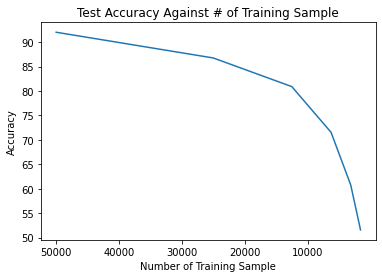

In [0]:
import matplotlib.pyplot as plt
import numpy as np
a = [92.01, 86.75, 80.89, 71.53, 60.76, 51.57]
b = [50000, 25000, 12500, 6250, 3120, 1560]
plt.plot(b, a)
plt.xticks(np.arange(10000, 50001, 10000))
ax = plt.gca()
ax.invert_xaxis()
plt.title("Test Accuracy Against # of Training Sample")
plt.xlabel("Number of Training Sample")
plt.ylabel("Accuracy")